In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.vdm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.vdm.vdm import VDM
from celldreamer.eval.optimal_transport import wasserstein

from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

In [2]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings["y_"+cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes["y_"+cov] = len(cov_names)
        else:
            num_classes["y_"+cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [3]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/new_architecture_learnt/c4ff452a-b1e3-4441-a369-42819272d5d6/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [4]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'noise_schedule': 'learnt_linear',
                            'gamma_min': -4.,
                            'gamma_max': 4.,
                            'antithetic_time_sampling': False,
                            'scaling_method': 'log_normalization',
                            'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': False,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 150,
                            'use_tanh_encoder': False}

**Initialization**

Initialize dataset 

In [5]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [6]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [7]:
generative_model = VDM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            sampling_covariate=dataset_config["sampling_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


<All keys matched successfully>

**Check the data**

In [8]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

In [9]:
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [10]:
# wasserstein(X_1, X_2)

More or less the range for the Wasserstein distance must be 100-200

**Collect checkpoints and run**

In [11]:
z_gen, z, X_generated = generative_model.sample(batch_size=10000, 
                                     n_sample_steps=100, 
                                     clip_samples=False,
                                     covariate="clusters")

sampling: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


In [12]:
X_generated.sum(1).mean()

tensor(1072.8101)

In [13]:
adata_original.layers["X_counts"].sum(1).mean()

1252.595

Analyze the results

**Create adata and check plots**

In [14]:
adata = sc.AnnData(X=X_generated.cpu().numpy())

In [15]:
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [16]:
adata.obs["size_factor"] = adata.X.sum(1)

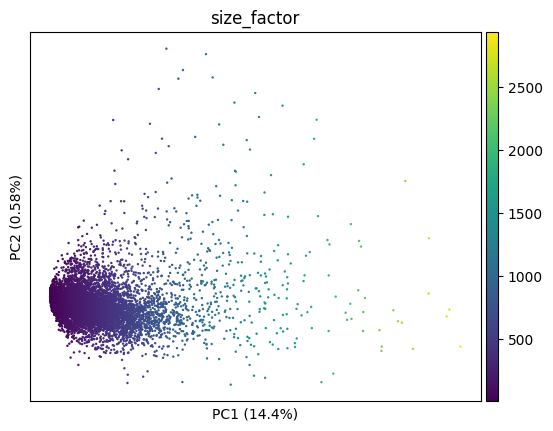

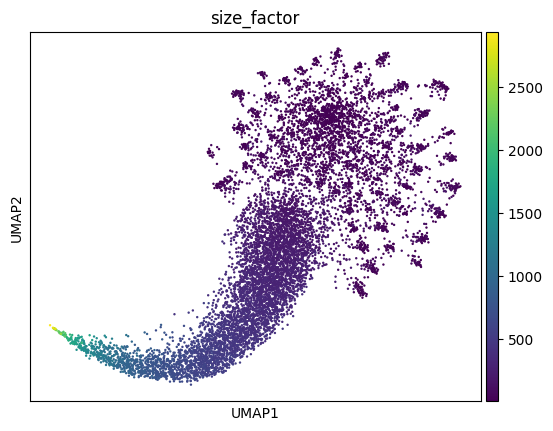

In [30]:
sc.pl.pca(adata, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata, color="size_factor")

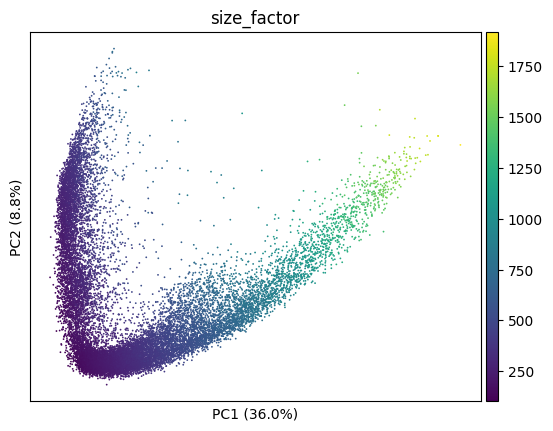

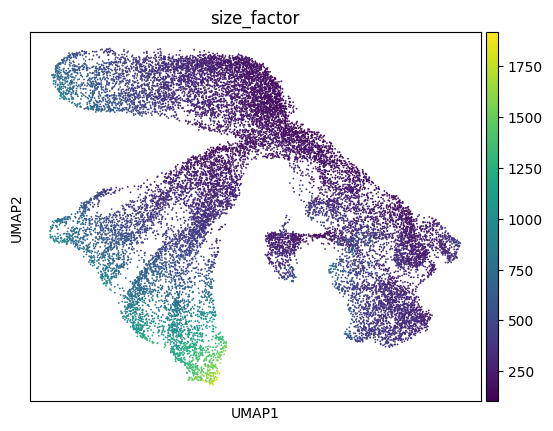

In [31]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

In [32]:
adata_original.X.sum(1).max()

1919.949

In [33]:
adata.X.sum(1).max()

2941.3018

(array([  7.,  17.,  47., 137., 464., 886., 367.,  66.,   6.,   3.]),
 array([-20.96759415, -17.19963074, -13.43166733,  -9.66370487,
         -5.89574146,  -2.12777805,   1.64018512,   5.40814829,
          9.17611122,  12.94407463,  16.71203804]),
 <BarContainer object of 10 artists>)

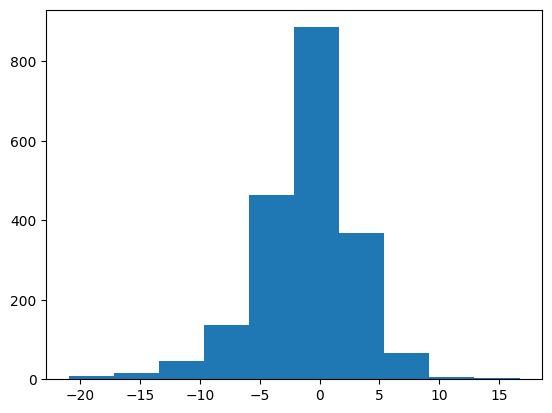

In [34]:
plt.hist(z_gen[5])

**Check architecture**

In [35]:
denoising_model = generative_model.denoising_model
denoising_model

MLPTimeStep(
  (embed_time): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
  )
  (embed_size_factor): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
  )
  (net_in): Linear(in_features=2000, out_features=512, bias=True)
  (down_blocks): ModuleList(
    (0): ResnetBlock(
      (net1): Sequential(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): SiLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (cond_proj_gamma): Linear(in_features=256, out_features=256, bias=False)
      (cond_proj_size_factor): Linear(in_features=256, out_features=256, bias=False)
      (net2): Sequential(
        (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [36]:
denoising_model.hidden_dim

128

In [37]:
denoising_model.embedding_dim

64

In [38]:
denoising_model.embed_size_factor

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): SiLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): SiLU()
)

In [39]:
denoising_model.embed_gamma

True

**Encode data**

In [40]:
obs_enc = []
with torch.no_grad():
    for batch in dataset:
        x = batch["X"].unsqueeze(0)
        x = generative_model._scale_batch(x)
        x_enc = generative_model.x0_from_x(x)
        obs_enc.append(x_enc)
obs_enc = torch.cat(obs_enc, dim=0)

(array([ 11.,  46., 103., 141., 159., 283., 401., 470., 320.,  66.]),
 array([-21.26672554, -18.51727104, -15.7678175 , -13.018363  ,
        -10.2689085 ,  -7.51945496,  -4.77000046,  -2.02054644,
          0.72890776,   3.47836185,   6.2278161 ]),
 <BarContainer object of 10 artists>)

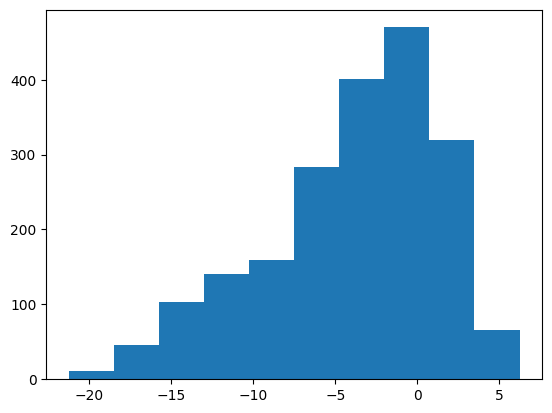

In [41]:
plt.hist(obs_enc[0])

In [42]:
z_gen.min()

tensor(-250.5473)